# Method 2 for Pitch and Yaw Prediction

Gathering necessary import

In [29]:
import os
import cv2
import joblib
import numpy as np
import pandas as pd
from cv2 import ORB_create
from skimage.feature import canny
from sklearn.decomposition import PCA
from skimage.transform import probabilistic_hough_line

from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from skimage.transform import probabilistic_hough_line
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

----

## Data Loading for Response Variables (Pitch and Yaw)

In [151]:
# Response Data Loading 

directory = 'labeled'
data = []

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        video_title = filename.split('.')[0]
        filepath = os.path.join(directory, filename)
        
        with open(filepath, 'r') as file:
            content = file.read().strip()
        
            values = list(map(float, content.split()))
            
            for i in range(0, len(values), 2):
                frame_number = i // 2
                pitch = values[i]
                yaw = values[i + 1]
                
                data.append([video_title, frame_number, pitch, yaw])

response_df = pd.DataFrame(data, columns=['video', 'frame', 'pitch', 'yaw'])
response_df = response_df.sort_values(by=['video', 'frame'])


-------
## Data Cleaning

I noticed that the sections with large NAs occured when the car was at a red light. Therefore, the pitch and yaw angle should carry over from the last frame before stopping. 

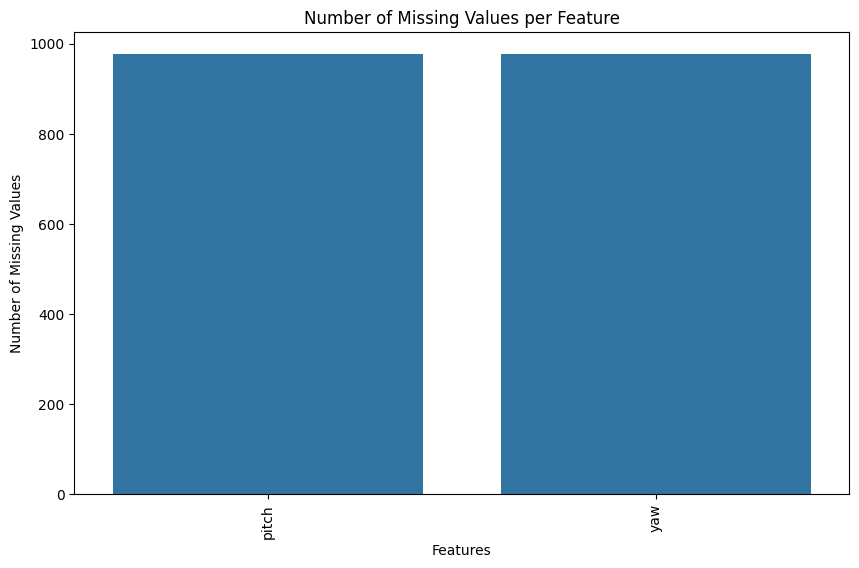

In [152]:
# Visualizing the amount of NAs 

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize missing values with a bar plot
def plot_missing_values(df):
    # Calculate the number of NaN values per column
    missing_values = df.isna().sum()
    
    # Filter out columns with no missing values
    missing_values = missing_values[missing_values > 0]
    
    # Plot the missing values
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values)
    plt.xticks(rotation=90)
    plt.title("Number of Missing Values per Feature")
    plt.ylabel("Number of Missing Values")
    plt.xlabel("Features")
    plt.show()

# Call the function on your dataset
plot_missing_values(response_df)



In [144]:
# Method 1 - Forward Fill

# Forward fill for 'pitch' column to impute missing values using the previous frame's value
response_df['pitch'] = response_df['pitch'].fillna(method='ffill')
response_df['yaw'] = response_df['yaw'].fillna(method='ffill')

In [155]:
# Method 2 - Discard NAs

response_df = response_df.dropna(subset=['pitch'])
response_df = response_df.dropna(subset=['yaw'])

----

## Feature Extraction

In [143]:
# Feature Extaction Model 

base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    return img_array

def extract_features_from_frames(frames_path):
    frame_files = sorted(os.listdir(frames_path)) 
    features = []
    
    for file in frame_files:
        image_path = os.path.join(frames_path, file)
        preprocessed_image = load_and_preprocess_image(image_path)
        feature = model.predict(preprocessed_image)
        features.append(feature.flatten())  
    
    return np.array(features)


video_folders = ['extracted_frames/video_0', 'extracted_frames/video_1', 
                 'extracted_frames/video_2', 'extracted_frames/video_3', 
                 'extracted_frames/video_4']

all_features = []

for video_folder in video_folders:
    features = extract_features_from_frames(video_folder)
    all_features.append(features)

all_features_labeled = np.vstack(all_features)


1/1 [==============================] - 0s 237ms/step


In [27]:
# Efficient net extraction 

import cv2
import numpy as np
import pandas as pd
from keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input
from keras.models import Model

base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Function to load and preprocess frames
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    return img_array

# Extract features from all frames
def extract_features_from_frames(frames_path):
    frame_files = sorted(os.listdir(frames_path)) 
    features = []
    
    for file in frame_files:
        image_path = os.path.join(frames_path, file)
        preprocessed_image = load_and_preprocess_image(image_path)
        feature = feature_extractor.predict(preprocessed_image)
        features.append(feature.flatten())  
    
    return np.array(features)

# Example usage for multiple video folders
video_folders = ['extracted_frames/video_0', 'extracted_frames/video_1', 
                 'extracted_frames/video_2', 'extracted_frames/video_3', 
                 'extracted_frames/video_4']

# Initialize a list to store features for each video
all_features = []

for video_folder in video_folders:
    features = extract_features_from_frames(video_folder)
    all_features.append(features)

all_features_labeled = np.vstack(all_features)

1/1 [==============================] - 0s 67ms/step
[[-0.09130282 -0.11896471  0.14145343 ... -0.06034365  0.08682252
  -0.17478694]
 [-0.08856755 -0.12764612  0.05194094 ... -0.02923862  0.14179282
  -0.16842519]
 [-0.08821066 -0.13368733  0.33243653 ... -0.05233102  0.13518135
  -0.179954  ]
 ...
 [-0.08692157 -0.1387388   0.25306642 ... -0.04748144  0.24167752
  -0.12833667]
 [-0.09005641 -0.14516765  0.14923821 ... -0.06778172  0.26277727
  -0.1276866 ]
 [-0.11099748 -0.13406888  0.13273047 ...  0.01995069  0.20024094
  -0.1162654 ]]


----

## Dimension Reduction and Feature Engineering

In [ ]:

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=50)
features_50d = pca.fit_transform(all_features_labeled)
features_50d
print(f'Feature shape: {features_50d.shape}')  


---

In [156]:
# Data quality problem - MANUAL FIX
all_features = all_features_labeled[:-4]
all_features = pd.DataFrame(all_features)
all_feat_df = pd.concat([response_df, all_features], axis=1)
all_feat_df

,video,frame,pitch,yaw,0,1,2,3,4,5,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
3596,0,0.0,0.033461,0.031492,0.0,0.0,0.0,0.000000,0.0,0.000000,...,3.046941,0.0,0.000000,0.0,9.912483,0.000000,0.0,0.0,0.000000,0.000000
3597,0,1.0,0.033320,0.031317,0.0,0.0,0.0,0.000000,0.0,0.000000,...,4.836332,0.0,0.000000,0.0,9.215641,0.000000,0.0,0.0,0.000000,0.000000
3598,0,2.0,0.033264,0.031203,0.0,0.0,0.0,0.000000,0.0,0.000000,...,7.962223,0.0,0.000000,0.0,9.291778,3.228694,0.0,0.0,0.000000,0.000000
3599,0,3.0,0.033280,0.031227,0.0,0.0,0.0,0.000000,0.0,0.000000,...,5.833879,0.0,0.000000,0.0,9.065094,3.966599,0.0,0.0,0.000000,0.000000
3600,0,4.0,0.033334,0.030963,0.0,0.0,0.0,0.000000,0.0,4.570822,...,1.163464,0.0,6.253798,0.0,1.880778,0.000000,0.0,0.0,1.333982,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.715306,0.0,0.000000,0.0,0.000000,0.486543,0.0,0.0,0.000000,0.000000
3353,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.526151,0.0,0.000000,0.0,0.000000,1.761306,0.0,0.0,0.000000,1.397362
3354,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.747221,0.0,0.000000,0.0,1.389564,3.779381,0.0,0.0,0.000000,0.000000
3355,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.000000,...,1.061912,0.0,0.000000,0.0,0.199783,8.398727,0.0,0.0,0.000000,0.000000


In [158]:
all_feat_df2 = all_feat_df.dropna(subset=['yaw'])
all_feat_df2

,video,frame,pitch,yaw,0,1,2,3,4,5,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
3596,0,0.0,0.033461,0.031492,0.0,0.0,0.0,0.0,0.0,0.000000,...,3.046941,0.0,0.000000,0.0,9.912483,0.000000,0.0,0.0,0.000000,0.0
3597,0,1.0,0.033320,0.031317,0.0,0.0,0.0,0.0,0.0,0.000000,...,4.836332,0.0,0.000000,0.0,9.215641,0.000000,0.0,0.0,0.000000,0.0
3598,0,2.0,0.033264,0.031203,0.0,0.0,0.0,0.0,0.0,0.000000,...,7.962223,0.0,0.000000,0.0,9.291778,3.228694,0.0,0.0,0.000000,0.0
3599,0,3.0,0.033280,0.031227,0.0,0.0,0.0,0.0,0.0,0.000000,...,5.833879,0.0,0.000000,0.0,9.065094,3.966599,0.0,0.0,0.000000,0.0
3600,0,4.0,0.033334,0.030963,0.0,0.0,0.0,0.0,0.0,4.570822,...,1.163464,0.0,6.253798,0.0,1.880778,0.000000,0.0,0.0,1.333982,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,4,1187.0,0.015339,0.052701,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,1.592585,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
1188,4,1188.0,0.015328,0.053488,0.0,0.0,0.0,0.0,0.0,0.309545,...,0.000000,0.0,0.000000,0.0,1.439570,0.000000,0.0,0.0,0.000000,0.0
1189,4,1189.0,0.015568,0.055036,0.0,0.0,0.0,0.0,0.0,0.287232,...,0.000000,0.0,1.334613,0.0,1.579130,0.000000,0.0,0.0,0.000000,0.0
1190,4,1190.0,0.015318,0.057053,0.0,0.0,0.0,0.0,0.0,0.588059,...,0.000000,0.0,2.814857,0.0,1.099298,0.000000,0.0,0.0,0.000000,0.0


## XGBoost Pitch Prediction 

Root Mean Squared Error for Pitch: 5.633046167534334e-06


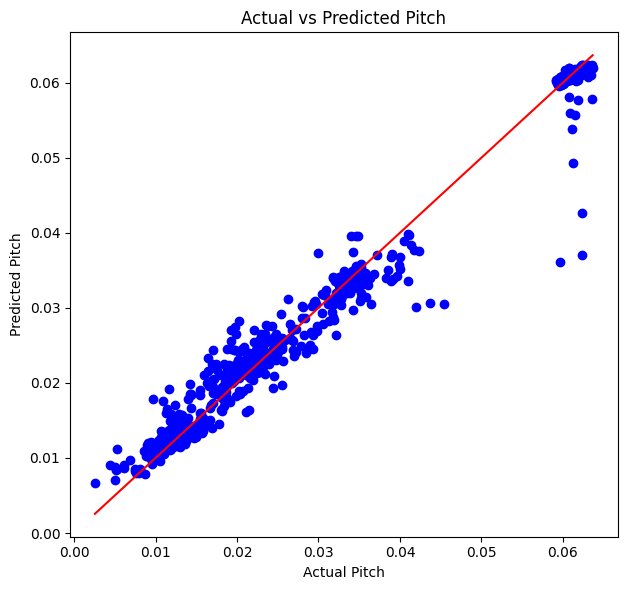

In [169]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib  # For saving and loading models

features_set = all_feat_df2.iloc[:,4:]
pitch = all_feat_df2['pitch']

# Step 1: Train-test split (Optional: can skip this step if you want to train on all data)
X_train, X_test, y_train, y_test = train_test_split(all_feat_df2.iloc[:,4:], all_feat_df2['pitch'], test_size=0.2, random_state=42)

# Train XGBoost for pitch prediction
xgb_pitch = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_pitch.fit(X_train, y_train)

# Step 3: Make predictions
predicted_pitch = xgb_pitch.predict(X_test)

# Step 4: Evaluate the model using mean squared error (MSE) for both pitch and yaw
mse_pitch = mean_squared_error(y_test, predicted_pitch)

print(f"Root Mean Squared Error for Pitch: {mse_pitch}")

# Step 5: Visualize the predictions vs actual for pitch and yaw
plt.figure(figsize=(12, 6))

# Plot for Pitch
plt.subplot(1, 2, 1)
plt.scatter(y_test, predicted_pitch, color='blue', label='Predicted vs Actual Pitch')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Pitch')
plt.ylabel('Predicted Pitch')
plt.title('Actual vs Predicted Pitch')

plt.tight_layout()
plt.show()


## XGBoost Yaw Prediction 

Mean Squared Error for Yaw: 1.150275366934099e-05


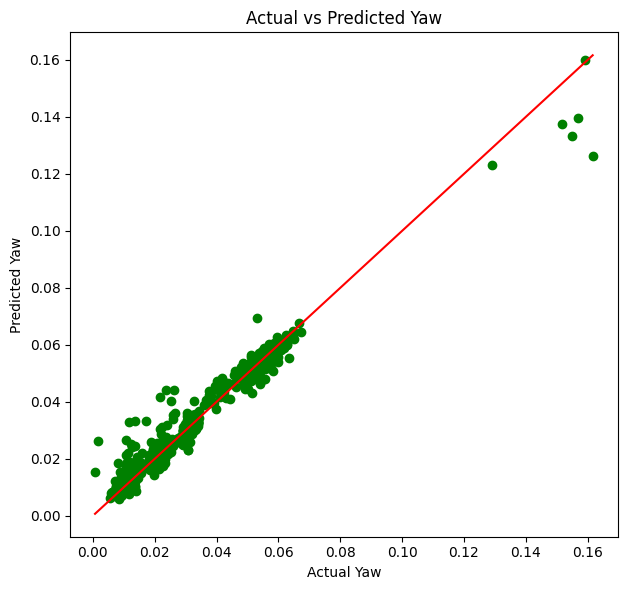

In [160]:
# Convert response data to numpy arrays
yaws = response_df['yaw'].values

# Step 1: Train-test split (Optional: can skip this step if you want to train on all data)
X_train, X_test, y_train, y_test = train_test_split(all_feat_df2.iloc[:,4:], all_feat_df2['yaw'], test_size=0.2, random_state=42)

# Train XGBoost for yaw prediction
xgb_yaw = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_yaw.fit(X_train, y_train)

# Save model
joblib.dump(xgb_yaw, 'xgb_yaw_model.pkl')

# Step 3: Make predictions
predicted_yaw = xgb_yaw.predict(X_test)

# Step 4: Evaluate the model using mean squared error (MSE) for both pitch and yaw
mse_yaw = mean_squared_error(y_test, predicted_yaw)  # Corrected line

print(f"Mean Squared Error for Yaw: {mse_yaw}")

# Step 5: Visualize the predictions vs actual for pitch and yaw
plt.figure(figsize=(12, 6))

# Plot for Yaw
plt.subplot(1, 2, 2)
plt.scatter(y_test, predicted_yaw, color='green', label='Predicted vs Actual Yaw')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Yaw')
plt.ylabel('Predicted Yaw')
plt.title('Actual vs Predicted Yaw')

plt.tight_layout()
plt.show()


In [161]:

# Predict pitch and yaw angles
predicted_pitch = xgb_pitch.predict(all_features)
predicted_yaw = xgb_yaw.predict(all_features)

# Reshape predictions to (6000, 2) if needed
predictions = np.column_stack((predicted_pitch, predicted_yaw))

# Save predictions to text files for evaluation
for i in range(5):
    start_index = i * 1200
    end_index = start_index + 1200
    np.savetxt(f'predictions_video_{i}.txt', predictions[start_index:end_index], fmt='%.6f')
    

---

## Prediction Evaluation 

In [167]:
import sys

# Step to evaluate predictions
if len(sys.argv) > 1:
    TEST_DIR = sys.argv[1]
else:
    raise RuntimeError('No test directory provided')

GT_DIR = 'labeled/'

def get_mse(gt, test):
    test = np.nan_to_num(test)
    return np.mean(np.nanmean((gt - test)**2, axis=0))

zero_mses = []
mses = []

for i in range(0, 5):
    gt = np.loadtxt(GT_DIR + str(i) + '.txt')
    zero_mses.append(get_mse(gt, np.zeros_like(gt)))

    test = np.loadtxt(f'predictions_video_{i}.txt')
    mses.append(get_mse(gt, test))

percent_err_vs_all_zeros = 100 * np.mean(mses) / np.mean(zero_mses)
print(f'YOUR ERROR SCORE IS {percent_err_vs_all_zeros:.2f}% (lower is better)')


YOUR ERROR SCORE IS 66.62% (lower is better)


----

## Linear Regression 

Mean Squared Error for Yaw (Linear Regression): 0.00035077209444193285


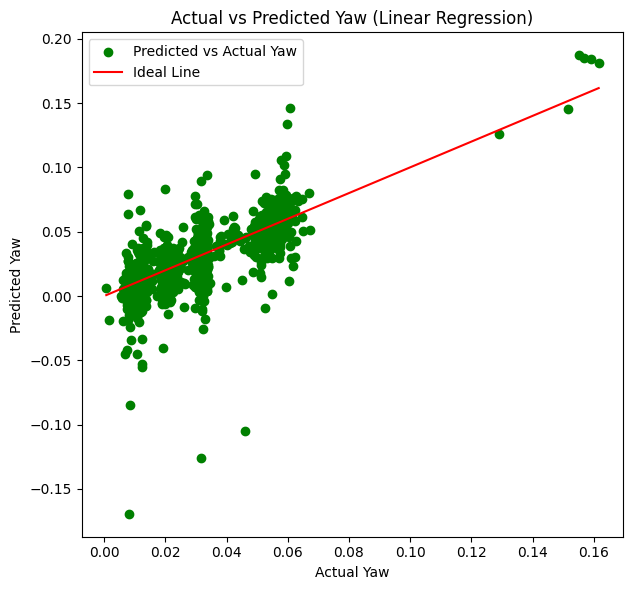

In [164]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 1: Train-test split for yaw prediction
X_train, X_test, y_train, y_test = train_test_split(all_feat_df2.iloc[:,4:], all_feat_df2['yaw'], test_size=0.2, random_state=42)

# Train Linear Regression model for yaw
lr_yaw = LinearRegression()
lr_yaw.fit(X_train, y_train)

# Step 2: Make predictions
predicted_yaw = lr_yaw.predict(X_test)

# Step 3: Evaluate the model using mean squared error (MSE) for yaw
mse_yaw = mean_squared_error(y_test, predicted_yaw)

print(f"Mean Squared Error for Yaw (Linear Regression): {mse_yaw}")

# Step 4: Visualize the predictions vs actual for yaw
plt.figure(figsize=(12, 6))

# Plot for Yaw
plt.subplot(1, 2, 2)
plt.scatter(y_test, predicted_yaw, color='green', label='Predicted vs Actual Yaw')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Line')
plt.xlabel('Actual Yaw')
plt.ylabel('Predicted Yaw')
plt.title('Actual vs Predicted Yaw (Linear Regression)')
plt.legend()

plt.tight_layout()
plt.show()


Mean Squared Error for Pitch (Linear Regression): 0.00012354189918131528


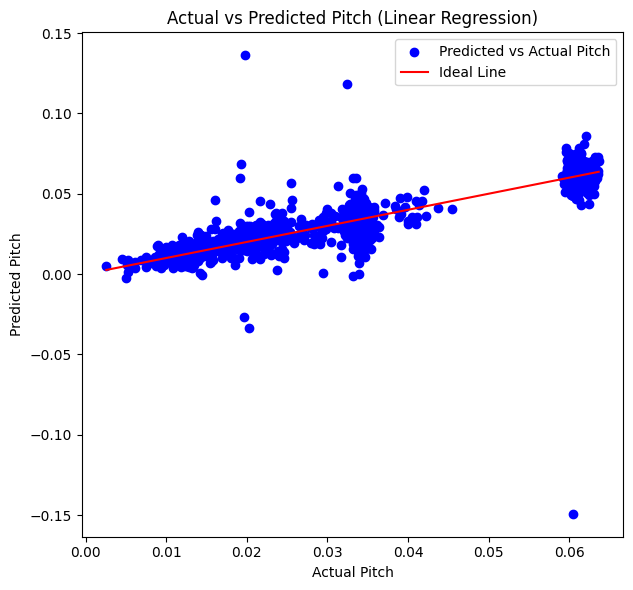

In [165]:
# Step 1: Train-test split for pitch prediction
X_train, X_test, y_train, y_test = train_test_split(all_feat_df2.iloc[:,4:], all_feat_df2['pitch'], test_size=0.2, random_state=42)

# Train Linear Regression model for pitch
lr_pitch = LinearRegression()
lr_pitch.fit(X_train, y_train)

# Step 2: Make predictions
predicted_pitch = lr_pitch.predict(X_test)

# Step 3: Evaluate the model using mean squared error (MSE) for pitch
mse_pitch = mean_squared_error(y_test, predicted_pitch)

print(f"Mean Squared Error for Pitch (Linear Regression): {mse_pitch}")

# Step 4: Visualize the predictions vs actual for pitch
plt.figure(figsize=(12, 6))

# Plot for Pitch
plt.subplot(1, 2, 1)
plt.scatter(y_test, predicted_pitch, color='blue', label='Predicted vs Actual Pitch')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Line')
plt.xlabel('Actual Pitch')
plt.ylabel('Predicted Pitch')
plt.title('Actual vs Predicted Pitch (Linear Regression)')
plt.legend()

plt.tight_layout()
plt.show()


In [166]:
import numpy as np

# Predict pitch and yaw angles using the linear regression models
predicted_pitch = lr_pitch.predict(all_features)
predicted_yaw = lr_yaw.predict(all_features)

# Combine predictions into a single array with two columns (pitch and yaw)
predictions = np.column_stack((predicted_pitch, predicted_yaw))

# Save predictions for each video into separate text files
for i in range(5):
    start_index = i * 1200
    end_index = start_index + 1200
    np.savetxt(f'predictions_video_{i}.txt', predictions[start_index:end_index], fmt='%.6f')


Predictions saved to text files successfully.
